# LiveProject - "Personalized Diagnosis"

## Reference Solution

## A. Jung 
- Linkedin: https://www.linkedin.com/in/aljung/
- Book: [mlbook.cs.aalto.fi](https://github.com/alexjungaalto/MachineLearningTheBasics/blob/master/MLBasicsBook.pdf)

## Import Packages 

First we import all required Python packages that we need during the project. 

In [1]:
# the pandas package provides tools for storing and manipulating dataframes
import pandas as pd                
# numpy package for working with arrays of numbers 
import numpy as np                 
# package for functions to plot numeric data
import matplotlib.pyplot as plt    
# package for using filesystem
import os                          
# the networkx package provides methods for generating and processing networks
import networkx as nx   
# datetime package provides methods to process date and time strings
import datetime as dt     
#  geopy package provides methods to process gps location data
from geopy.distance import geodesic   
#  import module preprocessing from package sklearn
from sklearn import preprocessing

## Milestone 1 - "Networked Data and Model"

Consider the location recordings stored in the file "PeopleLocations.csv" whose first line contains the column headers:

`ID; Latidute; Longitude; Date; Time; Covid19`

Each row contains entries for these columns separated by a semicolon `;`. Each row represents an individual with the column `ID` holding a string which is the identifier of the corresponding individual. The columns `Latitude` and `Longitude`are GPS coordinates of the individual at the time of recording. The fields `Date` and `Time` are strings representing the date and time of the recording. For each row, the last column `Covid19` contains `"y"` if the individual has been found Covid-19 positive at the time of recording. Otherwise the field `Covid19` contains `"n"`. 

We will also use features of audio recordings for the individuals listed in "PeopleLocations.csv". These features are stored in the file "PeopleLocationsFeatures.csv" whose first line contains the column headers:

`ID;x1;x2;x3;x4;x5;x6`

Each row contains entries for these columns separated by a semicolon `;`. Each row represents an individual with the column `ID` holding a string which is the identifier of the corresponding individual. The columns `x1`,...,`x6` are numeric features extracted from an audio recording of the individual.

This milestone requires to construct a `networkx` object `G`. The object `G` represens an undirected contact network whose nodes are the individuals listed in "PeopleLocations.csv". The network `G` has an edge between nodes that represent individuals for which there are location recordings in "PeopleLocations.csv" within a geodesic distance of 2 meters. 

Each node in `G` should have the attributes 

- "y": which is equal to 1 if the corresponding location recording indicates an infection and equal to 0 otherwise.

- "x": six features x1,...,x6 of an audio recording for this individual. These features are stored in "PeopleLocationsFeatures.csv".

- "w": this attribute contains the weight vector w=(w1,...,w6)^{T} for a linear classifier

- "b": the intercept term for a linear classifier 

In [2]:
# read in data from PeopleLocations.csv into dataframe "df"
df = pd.read_csv('PeopleLocations.csv',sep=';')    

# read in data from PeopleLocationsFeatures.csv into dataframe "df_features"
df_features = pd.read_csv('PeopleLocationsFeatures.csv',sep=';')    
nrfeatures=6

# store the first column of dataframe df in variable "IDcol"

IDcol = df.columns[0]

# determine a list of different individuals for which there is at least one record in the csv file

uniquepart = df[IDcol].unique()       

# count the number of different individuals. this will be the number of nodes in the contace network

nrnodes = len(uniquepart)        

In [3]:
# create networkx object `G` by adding nodes for each individual with a record in "PeopleLocations.csv"

G = nx.Graph()

# we use a label encoder used to transfrom values 'y'/'n' for Covid19 infection to values 1 and 0
le = preprocessing.LabelEncoder()                
le.fit(["n", "y"])

# iterate over individuals represented by network nodes indexed by nodeidx=0,1,...

for nodeidx in range(nrnodes): 
    
    # read in identifier of individual from list `uniquepart` and store in variable "personid"
    personid = uniquepart[nodeidx]
    
    # create dataframe "dmydf" by selecting all rows from dataframe `df` with attribute `ID` equal to `personid`
    dmydf = pd.DataFrame(df.loc[df['ID'] == personid].copy())
    # create dataframe "dmydf_features" by selecting all rows from dataframe `df` with attribute `ID` equal to `personid`
    dmydf_features = pd.DataFrame(df_features.loc[df_features['ID'] == personid].copy())
    
    # reset index of dataframe dmydf 
    dmydf.reset_index(drop=True, inplace=True) 
    # reset index of dataframe dmydf_features 
    dmydf_features.reset_index(drop=True, inplace=True) 
    
    # read in latitude of first location recording in `dmydf` and store in variable `latitude`
    latitude=dmydf.loc[0,['Lat']][0]
    
    # read in longitude of first location recording in `dmydf` and store in variable `longitude`
    longitude=dmydf.loc[0,['Lon']][0]
    
    # read in Covid19 infection status of first location recording in `dmydf` and store in variable `valtmp`
    valtmp=dmydf.loc[0,['Covid19']][0]
    
    # use le.transform() to map the infection status `valtmp` as `y`->1 and `n`-> 0
    infected=le.transform([valtmp])
    
    # read in the date of the recording and store in variable date_tmp
    date_tmp = dt.datetime.strptime(dmydf.loc[0,['Date']][0], '%d-%m-%Y').date() 
    
    # read in the time of the recording and store in variable time_tmp
    time_tmp = dt.datetime.strptime(dmydf.loc[0,['Time']][0], '%H:%M:%S').time()
    
    # combine date and time of location racording using `datetime.combine()
    mydatetime = dt.datetime.combine(date_tmp, time_tmp)
    
    # add a node with index `nodeidx`
    G.add_node(nodeidx)
    # set the node attribute "name" to the string stored in "personid"
    G.nodes[nodeidx]['name']= personid
    # set the node attribute "coords" to a numpy array with entries "latitude" and "longitude"
    G.nodes[nodeidx]['coords']= np.array([latitude,longitude])
    # set the node attribute "timestamp" to the value of "mydatetime"
    G.nodes[nodeidx]['timestamp'] = mydatetime
    # set the node attribute "y" equal to 1 if individual has been reported as Covid-19 infected and 0 otherwise
    G.nodes[nodeidx]['y'] = infected[0] 
    # set the node attribute "w" to a numpy array of shape (6,) and entries all zero
    G.nodes[nodeidx]['w'] = np.zeros(nrfeatures)    
    # set the node attribute "b" to 0.0
    G.nodes[nodeidx]['b'] = 0.0  

    # read in the features x1,...,x6 from dataframe "dmydf_features" and store in numpy array "dmyvec"
    dmyvec = np.zeros(nrfeatures)
    for iterfeature in range(nrfeatures):
        keytmp = "x%d"% (iterfeature+1)
        dmyvec[iterfeature]=dmydf_features.loc[0,[keytmp]][0]
    
    # set the node attribute "x" to the numpy array "dmyvec"
    G.nodes[nodeidx]['x'] = dmyvec


To build the contact network we add an edge between nodes representing individuals for which we can find location recording which are closer than 2 meters. 

In [4]:
# two nested for-loops over node indices 0,1,...,nrnodes-1 
# the loop variables are named "nodeidx1" and "nodeidx2"

for nodeidx1 in range(nrnodes): 
    for nodeidx2 in range(nrnodes): 
        # test if nodeidx1 is different from nodeidx2
        if nodeidx1!=nodeidx2 : 
            # compute the geodesic distance between individualas "nodeidx1" and "nodeidx2" in meters 
            nodedist=geodesic(G.nodes[nodeidx1]['coords'],G.nodes[nodeidx2]['coords']).meters
            # if distance is below two meters connect invididuals by and edge. 
            if  nodedist<2: 
                G.add_edge(nodeidx1,nodeidx2)

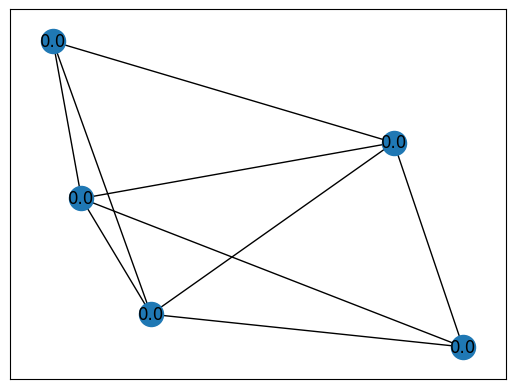

In [5]:
# Create new graph object "SubGraph" using G.subgraph() consisting of nodes 0,1,2,3,4
SubGraph = G.subgraph([0,1,2,3,4]) 
# read out node attribute `b`from all nodes in "SubGraph" and store in variable "labels"
labels = nx.get_node_attributes(SubGraph, 'b') 
# plot "SubGraph" using nx.draw_networkx() with "labels" as node labels 
nx.draw_networkx(SubGraph,labels = labels ) 

## Milestone 2 - "Personalized Diagnosis "

This milestone requires you to learn personalized predictors for a Covid-19 infection. To this end you will the combine the gradient descent algorithm for logistic regression with a network averaging method for aggregating local gradients computed for each individual. 

More formally, we assign each invidiual $i$ a linear classifier with weight vector $\mathbf{w}^{(i)}=\big(w^{(i)}_{1},\ldots,w^{(i)}_{6}\big)^{T}$ and intercept (bias) term $b^{(i)}$. Given an individual $i$ with features $\mathbf{x}^{(i)}$ (extracted from an audio recording) we diagnose a Covid-19 infection if $\mathbf{w}^{T} \mathbf{x}^{(i)} +b^{(i)} \geq0$. To learn the weight vector and  intercept term for the node $i$ that belongs to the component $\mathcal{C}$ of the contact network, we use a sufficient number of gradient descent steps
$$ \mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \alpha \mathbf{g}^{(k)} \mbox{ with } \mathbf{g}^{(k)}= (1/|\mathcal{C}|) \sum_{j \in \mathcal{C}} \big(h\big(\big(\mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(j)}\big) - y^{(j)}\big) \mathbf{x}^{(j)} $$ 
and
$$ b^{(k+1)} = b^{(k)} - \alpha v^{(k)} \mbox{ with } v^{(k)}= (1/|\mathcal{C}|) \sum_{j \in \mathcal{C}} \big(h\big(\big(\mathbf{w}^{(k)}\big)^{T} \mathbf{x}^{(j)}\big) - y^{(j)}\big)  $$. 

We will estimate the gradients $\mathbf{g}^{(k)}$ and $v^{(k)}$ using the averaging algorithm that we used in Project 2 for computing the average infection rates.

The code snippet below implements the sigmoid function which maps the ouptut of a linear predictor to an estimate for the probability of having a Covid-19 infection

In [6]:
def sigmoid(X, theta):
    
    z = np.dot(X, theta[1:]) + theta[0]
    
    return 1.0 / ( 1.0 + np.exp(-z))

In [11]:
weights_tmp_dic=nx.get_node_attributes(G,'w')
weights_tmp = np.zeros((nrnodes,nrfeatures))
intercept_tmp_dic=nx.get_node_attributes(G,'b')
intercept_tmp = np.zeros(nrnodes)
features_tmp_dic=nx.get_node_attributes(G,'x')
features_tmp = np.zeros((nrnodes,nrfeatures))
label_tmp_dic=nx.get_node_attributes(G,'y')
label_tmp = np.zeros(nrnodes)



for iternode in range(nrnodes):
      weights_tmp[iternode,:] = weights_tmp_dic[iternode]
      intercept_tmp[iternode] = intercept_tmp_dic[iternode]
      features_tmp[iternode,:] = features_tmp_dic[iternode]
      label_tmp[iternode] = label_tmp_dic[iternode]

# set step-size
alpha = 1/10
    
weights_old = weights_tmp.copy() 
intercept_old = intercept_tmp.copy()
gradient_tmp = np.zeros((nrnodes,nrfeatures+1)) # each row hold the gradient for intercept and weights 
gradient_old = np.zeros((nrnodes,nrfeatures+1))

nriters=50

# create "Metropolis-Hastings" weights and store them in numpy array `W_MH`
W_MH = np.zeros((nrnodes,nrnodes)) # create array for MH weights and init to all zeroes
# iterate over all edges in the contact network G
for edge in G.edges(): 
    node_a = edge[0]
    node_b = edge[1]
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the contact network G
for nodedmy in G.nodes(): 
# set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[nodedmy,nodedmy] = 1-np.sum(W_MH[nodedmy,:])
    
# set number of iterations for gradient descent to default value 200
nrlogregiters = 10

# main loop for the federated learning algorithm 
# each iteration amounts to network averaging of all local gradients 

for iterlogreg in range(nrlogregiters):
# compute gradients at each node 
    for iternode in range(nrnodes):
# stack weights and intercept into theta
        theta = np.hstack((intercept_tmp[iternode],weights_tmp[iternode]))
        # compute sgmoid function of predictor value w^T x
        hx = sigmoid(features_tmp[iternode], theta)
        # calculate error
        error = hx - label_tmp[iternode]
        # compute gradient for local loss function and store in gradient_tmp
        gradient_tmp[iternode,:] = np.hstack((error,error*features_tmp[iternode]))
          
    
    
# average gradients using nriters consensus iterations
    for iterdmy in range(nriters):
        # read in current values of "Rate" attributes into numpy array `graphsigold`
        gradient_old = gradient_tmp 
        # update estimate "gradient_tmp" by applying W_MH to current estimate
        gradient_tmp = np.dot(W_MH, gradient_old)
    
    # do a gradient descent step for intercept_tmp using step size alpha
    intercept_tmp -= alpha*gradient_tmp[:,0]
    # do a gradient descent step for weights_tmp using step size alpha
    weights_tmp -= alpha*gradient_tmp[:,1:]

    


# loop over all nodes in the contact network G store the weights in "weights_tmp" in the node attribute "weights"
# store the incepts in "intercept_tmp" in the node attribute "intercep"

for node_i in G.nodes(data=False): 
    G.nodes[node_i]['w'] = weights_tmp[node_i]
    G.nodes[node_i]['b'] = intercept_tmp[node_i]
  
    print("weights node %d :"%node_i,weights_tmp[node_i]) 

    



weights node 0 : [-0.23469594 -0.00054513  0.00647552  0.00890055  0.00266389  0.00413673]
weights node 1 : [-0.23476983 -0.0005496   0.00647931  0.0088951   0.00266511  0.00413988]
weights node 2 : [-0.23485814 -0.00055493  0.00648373  0.00888859  0.00266654  0.00414368]
weights node 3 : [-0.23474784 -0.00054828  0.00647826  0.00889672  0.00266477  0.00413892]
weights node 4 : [-0.23481243 -0.00055213  0.00648095  0.008892    0.00266563  0.00414184]
weights node 5 : [-0.23478319 -0.00055036  0.00647943  0.00889416  0.00266515  0.0041406 ]
weights node 6 : [-0.23481243 -0.00055213  0.00648095  0.008892    0.00266563  0.00414184]
weights node 7 : [-0.23486645 -0.00055535  0.00648308  0.00888806  0.00266631  0.00414432]
weights node 8 : [-0.23477578 -0.00054996  0.00647958  0.00889466  0.0026652   0.00414014]
weights node 9 : [-0.2330514  -0.00044399  0.00636886  0.0090236   0.00262922  0.00407255]
weights node 10 : [-0.23483358 -0.00055343  0.00648229  0.00889042  0.00266607  0.00414268

# summary of the project

In this project, we will build a contact network from the location data of the individuals. Then we will use the contact network to learn personalized predictors for a Covid-19 infection. To this end you will the combine the gradient descent algorithm for logistic regression with a network averaging method for aggregating local gradients computed for each individual. As a result, we will have a personalized predictor for each individual in the contact network. 
